In [2]:
import os
import numpy as np
import pandas as pd

from scipy import corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn import cluster, metrics
import scipy.io

from nilearn import plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pathlib import Path
home_dir = str(Path.home())
work_dir = os.path.join(home_dir, 'Box/CogNeuroLab/Aging Decision Making R01')

Atlas ROIs are located in nifti image (4D) at: /Users/megmcmahon/Box/CogNeuroLab/Aging Decision Making R01/Analysis/schaefer400/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


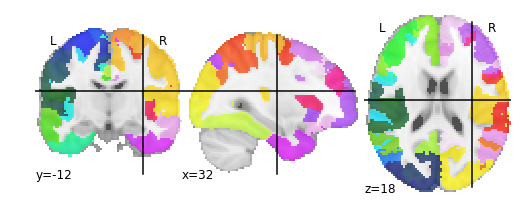

In [4]:
from nilearn import datasets
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir=os.path.join(work_dir, 'Analysis/schaefer400'))
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)  # 4D data
plotting.plot_roi(atlas_filename)

In [5]:
schaefer_coords = np.loadtxt(os.path.join(work_dir, 'Analysis/schaefer400/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'), delimiter = ',', skiprows=2, usecols=(2,3,4))
schaefer_coords = tuple(map(tuple, schaefer_coords))
schaefer_coords[:5]

labels_df = pd.DataFrame(labels, columns = ['labels'], dtype=str)
dmn_mask = labels_df.index[labels_df['labels'].str.contains('Default')]
fpn_mask = labels_df.index[labels_df['labels'].str.contains('Cont')]

## Executive Function and DMN Connectivity

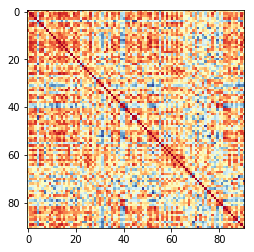

In [6]:
fcmat_dmn = scipy.io.loadmat(os.path.join(work_dir, 'Analysis/rest/REST_OA_dmn_cor.mat'), squeeze_me=True)['OA_dmn_cormat']

plt.imshow(fcmat_dmn[:,:,1], interpolation='None', cmap='RdYlBu_r')

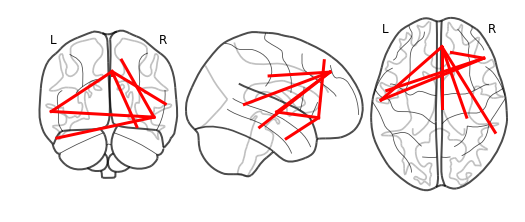

In [7]:
adj = np.loadtxt(os.path.join(work_dir, 'Analysis/rest/nbs_results/dmn_ef_adj.txt'))
plotting.plot_connectome(adj, np.asarray(schaefer_coords)[dmn_mask], node_size=0)

In [8]:
edgelist = np.where(np.triu(adj)==1)
edgelist

(array([19, 47, 47, 56, 69, 69, 70]), array([73, 69, 73, 69, 80, 86, 73]))

In [9]:
fcmat_dmn[edgelist[0], edgelist[1], 0]

array([ 0.56610183, -0.1681285 ,  0.24572394, -0.1776394 ,  0.2799803 ,
        0.30656014,  0.33380734])

In [10]:
cor = []

for subject in range(0, np.ma.size(fcmat_dmn, 2)):
    cor.append(fcmat_dmn[edgelist[0], edgelist[1], subject])

cor = np.asarray(cor)

In [11]:
ef = pd.read_csv(os.path.join(work_dir, 'Analysis/neuropsych/oa_neuropsych_zscores.csv'), usecols=['Executive function']).values

Text(0.07, 0.5, 'Executive Function')

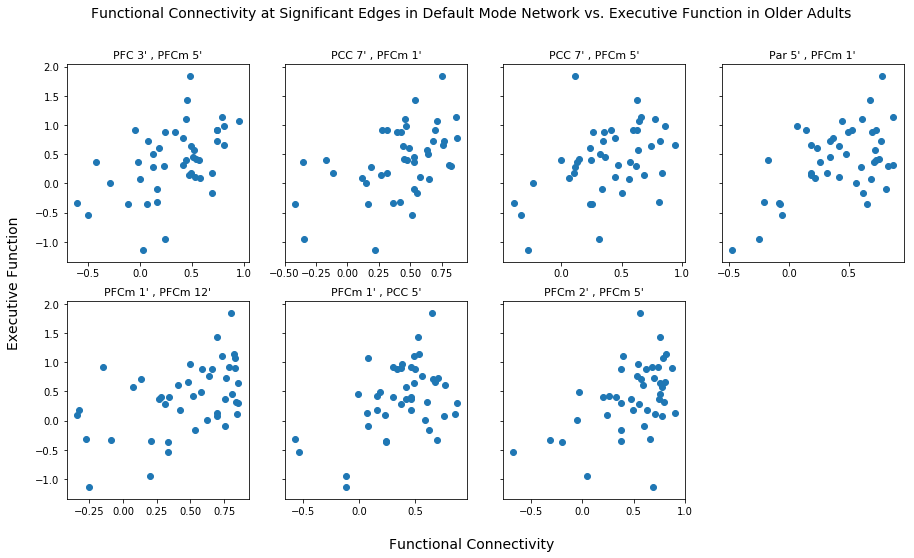

In [12]:
n_wide = int(np.floor(len(edgelist[0])/2 + 1))
fig, axes = plt.subplots(2, n_wide,figsize=[15,8], sharey=True)
fig.suptitle('Functional Connectivity at Significant Edges in Default Mode Network vs. Executive Function in Older Adults', size=14)

for edge in range(0,len(edgelist[0])):
    if edge < n_wide:
        axes[0, edge].scatter(cor[:,edge], ef)
        axes[0, edge].set_title(' '.join(str(labels[dmn_mask][edgelist[0][edge]]).split('_')[3:5]) + ' , ' + ' '.join(str(labels[dmn_mask][edgelist[1][edge]]).split('_')[3:5]), size=11)
    else:
        axes[1, edge-n_wide].scatter(cor[:,edge], ef)
        axes[1, edge-n_wide].set_title(' '.join(str(labels[dmn_mask][edgelist[0][edge]]).split('_')[3:5]) + ' , ' + ' '.join(str(labels[dmn_mask][edgelist[1][edge]]).split('_')[3:5]), size=11)

fig.delaxes(axes[1][3])

fig.text(0.5, 0.04, 'Functional Connectivity', ha='center', size=14)
fig.text(0.07, 0.5, 'Executive Function', va='center', rotation='vertical', size=14)

# plt.gca().legend(loc='center left', bbox_to_anchor=(1.2, 0.9))


In [15]:
import statsmodels.api as sm
for edge in range(0,7):
    print('\n \n' + str(labels[dmn_mask][edgelist[0][edge]])[23:] + ' , ' + str(labels[dmn_mask][edgelist[1][edge]])[23:])
    mod = sm.OLS(cor[:,edge], ef)
    res = mod.fit()
    print(res.summary())


 
PFC_3' , PFCm_5'
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     35.81
Date:                Fri, 30 Aug 2019   Prob (F-statistic):           3.86e-07
Time:                        18:23:22   Log-Likelihood:                -17.508
No. Observations:                  44   AIC:                             37.02
Df Residuals:                      43   BIC:                             38.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4664      0.078

## Circadian Measures

In [13]:
fcmat_wb_cr = scipy.io.loadmat(os.path.join(work_dir, 'Analysis/rest/rest_wb-cr_cor.mat'), squeeze_me=True)['wb_cr_cormat']
fcmat_dmn_cr = scipy.io.loadmat(os.path.join(work_dir, 'Analysis/rest/rest_dmn-cr_cor.mat'), squeeze_me=True)['dmn_cr_cormat']
fcmat_fpn_cr = scipy.io.loadmat(os.path.join(work_dir, 'Analysis/rest/rest_fpn-cr_cor.mat'), squeeze_me=True)['fpn_cr_cormat']

IS = pd.read_csv(os.path.join(work_dir, 'Analysis/cr_data_for_dsnmat.csv'), usecols=['IS']).values
RA = pd.read_csv(os.path.join(work_dir, 'Analysis/cr_data_for_dsnmat.csv'), usecols=['RA']).values

### Interdaily Stability

**Whole Brain**

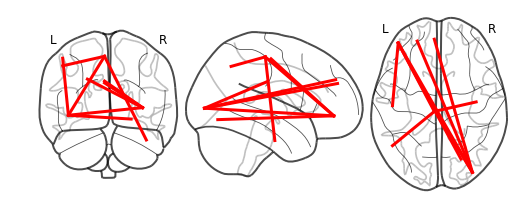

In [159]:
adj = np.loadtxt(os.path.join(work_dir, 'Analysis/rest/nbs_results/adj_IS-wb.txt'))
plotting.plot_connectome(adj, np.asarray(schaefer_coords), node_size=0)

In [160]:
edgelist = np.where(np.triu(adj)==1)
fcmat_wb_cr[edgelist[0], edgelist[1], 0]

array([ 0.19866593,  0.72547033,  0.58346249, -0.08016062, -0.57253334,
        0.3396356 , -0.22139942, -0.0379323 , -0.12895976])

In [161]:
cor = []

for subject in range(0, np.ma.size(fcmat_wb_cr, 2)):
    cor.append(fcmat_wb_cr[edgelist[0], edgelist[1], subject])

cor = np.asarray(cor)

Text(0.07, 0.5, 'Interdaily Stability')

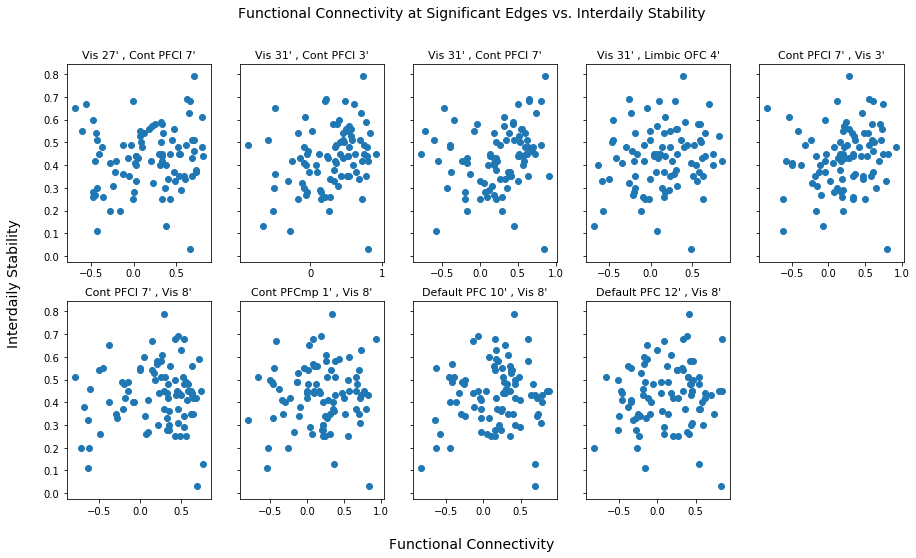

In [90]:
n_wide = int(np.floor(len(edgelist[0])/2 + 1))
fig, axes = plt.subplots(2, n_wide,figsize=[15,8], sharey=True)
fig.suptitle('Functional Connectivity at Significant Edges vs. Interdaily Stability', size=14)

for edge in range(0,len(edgelist[0])):
    if edge < n_wide:
        axes[0, edge].scatter(cor[:,edge], IS)
        axes[0, edge].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)
    else:
        axes[1, edge-n_wide].scatter(cor[:,edge], IS)
        axes[1, edge-n_wide].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)

fig.delaxes(axes[1][4])

fig.text(0.5, 0.04, 'Functional Connectivity', ha='center', size=14)
fig.text(0.07, 0.5, 'Interdaily Stability', va='center', rotation='vertical', size=14)

# plt.gca().legend(loc='center left', bbox_to_anchor=(1.2, 0.9))


### Edges associated with IS at whole brain level mainly comprise connections between visual areas and frontal or default mode network areas.

In [139]:
IS_n = pd.read_csv(os.path.join(work_dir, 'Analysis/cr_data_for_dsnmat.csv'), usecols=['record_id', 'IS'])
ef_n = pd.read_csv(os.path.join(work_dir, 'Analysis/neuropsych/ef_zscores.csv'), usecols=['record_id', 'ef_zscore'])
print(len(ef_n))

#making sure subject numbers are aligned 
ef_n = pd.merge(IS_n, ef_n, on='record_id')
print(len(ef_n))

cor_n = pd.DataFrame(cor)
df = pd.concat((cor_n, ef_n), axis=1)

ef_n = ef_n['ef_zscore'].values

df.index[df['record_id'] > 40000] #is 47, so for YA do [:47] and for OA do [47:]
df[:5]

92
88


,0,1,2,3,4,5,6,7,8,record_id,IS,ef_zscore
0,0.198666,0.725470,0.583462,-0.080161,-0.572533,0.339636,-0.221399,-0.037932,-0.128960,30004,0.42,-0.836570
1,0.531239,0.755226,0.612038,0.317917,0.748479,0.732584,0.102619,0.364435,0.454289,30008,0.45,-0.769594
2,0.372056,-0.088354,0.362255,0.139094,0.653825,0.352416,0.221435,0.428202,0.435280,30009,0.30,0.417524
3,0.609794,0.273159,0.331008,-0.001615,0.477330,0.528041,0.240295,0.721933,-0.503076,30012,0.34,1.200696
4,0.597801,0.509161,0.389415,-0.185797,0.470485,0.632755,0.518482,0.398717,-0.256763,30015,0.35,-1.281553


### No significant relationships between functional connectivity at edges associated with higher interdaily stability at a whole brain level and executive function or memory.

Text(0.07, 0.5, 'Executive Function')

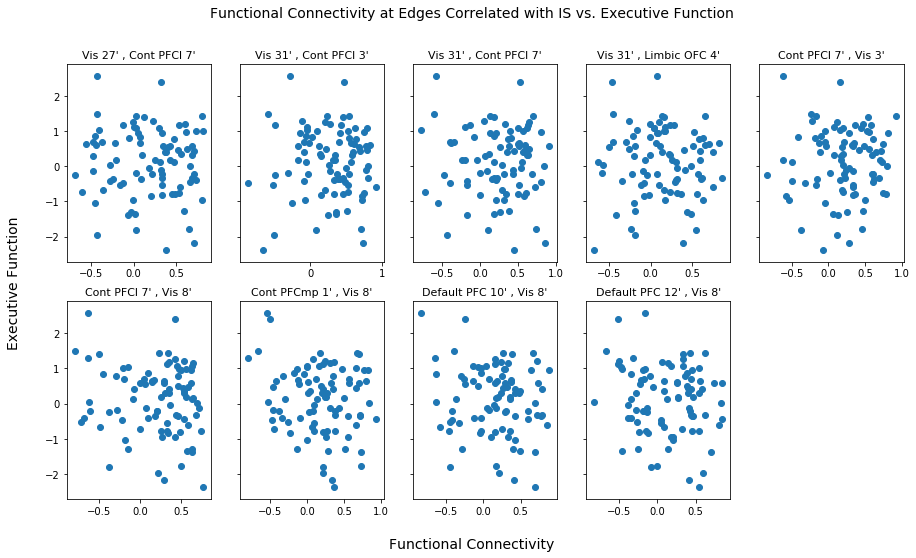

In [116]:
n_wide = int(np.floor(len(edgelist[0])/2 + 1))
fig, axes = plt.subplots(2, n_wide,figsize=[15,8], sharey=True)
fig.suptitle('Functional Connectivity at Edges Correlated with IS vs. Executive Function', size=14)

for edge in range(0,len(edgelist[0])):
    if edge < n_wide:
        axes[0, edge].scatter(cor[:,edge], ef_n)
        axes[0, edge].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)
    else:
        axes[1, edge-n_wide].scatter(cor[:,edge], ef_n)
        axes[1, edge-n_wide].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)

fig.delaxes(axes[1][4])

fig.text(0.5, 0.04, 'Functional Connectivity', ha='center', size=14)
fig.text(0.07, 0.5, 'Executive Function', va='center', rotation='vertical', size=14)


In [140]:
import statsmodels.api as sm
for edge in range(0,len(edgelist[0])):
    print('\n \n' + ' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]))
    mod = sm.OLS(cor[:,edge], ef_n)
    res = mod.fit()
    print(res.summary())


 
Vis 27' , Cont PFCl 7'
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                  0.001242
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.972
Time:                        13:57:06   Log-Likelihood:                -53.493
No. Observations:                  88   AIC:                             109.0
Df Residuals:                      87   BIC:                             111.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0017     

In [166]:
IS_n = pd.read_csv(os.path.join(work_dir, 'Analysis/cr_data_for_dsnmat.csv'), usecols=['record_id', 'IS'])
mem = pd.read_csv(os.path.join(work_dir, 'Analysis/neuropsych/oa_neuropsych_zscores.csv'), usecols=['record_id', 'Memory'])
print(len(mem))

#making sure subject numbers are aligned 
cor_n = pd.DataFrame(cor)
IS_cor = pd.concat((IS_n, cor_n), axis=1)
mem = pd.merge(mem, IS_cor, on='record_id')
print(len(mem))

cor_n = mem.drop(['record_id', 'Memory', 'IS'], axis=1).values
print(len(cor_n))
mem_n = mem['Memory'].values
print(len(mem_n))

44
41
41
41


In [167]:
import statsmodels.api as sm
for edge in range(0,len(edgelist[0])):
    print('\n \n' + ' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]))
    mod = sm.OLS(cor_n[:,edge], mem_n)
    res = mod.fit()
    print(res.summary())


 
Vis 27' , Cont PFCl 7'
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                  0.007648
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.931
Time:                        14:39:44   Log-Likelihood:                -27.018
No. Observations:                  41   AIC:                             56.04
Df Residuals:                      40   BIC:                             57.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0082     

**Default Mode Network**

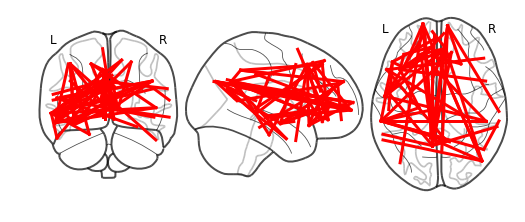

In [18]:
adj = np.loadtxt(os.path.join(work_dir, 'Analysis/rest/nbs_results/adj_IS-dmn.txt'))
plotting.plot_connectome(adj, np.asarray(schaefer_coords)[dmn_mask], node_size=0)

In [19]:
edgelist = np.where(np.triu(adj)==1)
fcmat_dmn_cr[edgelist[0], edgelist[1], 0]

array([ 0.55686511,  0.59223094,  0.53460587, -0.05594413,  0.24952942,
        0.37911208,  0.27721147,  0.81619696,  0.50557893, -0.26803176,
        0.63405551,  0.70315057,  0.5112792 ,  0.81415753, -0.05901004,
        0.58098434, -0.02942596,  0.41968207,  0.13729175,  0.35342099,
        0.32577106,  0.43795984,  0.5340853 ,  0.23710119,  0.79624984,
        0.50051149,  0.79783575,  0.74077442, -0.13221747,  0.6879338 ,
        0.72801821, -0.02941171,  0.90379686,  0.21184216,  0.59388516,
        0.3882846 , -0.14835872,  0.16335767,  0.34206122, -0.12762384,
       -0.13354045, -0.36868454, -0.15064793, -0.08503513,  0.0391001 ,
        0.0531522 ,  0.66921834, -0.65539345,  0.11288199,  0.00598322,
        0.09101172, -0.18935551,  0.41207485, -0.21184389, -0.39995366,
        0.49815462, -0.07440211,  0.16939391,  0.12958216,  0.63840992,
        0.75021788,  0.53626071,  0.49315632])

In [20]:
cor = []

for subject in range(0, np.ma.size(fcmat_wb_cr, 2)):
    cor.append(fcmat_wb_cr[edgelist[0], edgelist[1], subject])

cor = np.asarray(cor)

In [21]:
len(edgelist[0])

63

### Relative Amplitude

**Whole Brain**

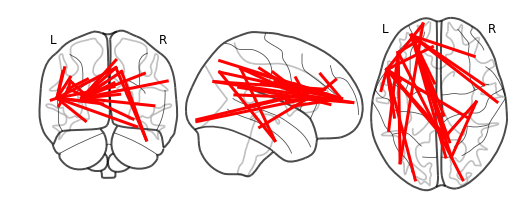

In [141]:
adj = np.loadtxt(os.path.join(work_dir, 'Analysis/rest/nbs_results/adj_RA-wb.txt'))
plotting.plot_connectome(adj, np.asarray(schaefer_coords), node_size=0)

In [142]:
edgelist = np.where(np.triu(adj)==1)
fcmat_wb_cr[edgelist[0], edgelist[1], 0]

array([-0.36673003, -0.11528816, -0.45044064, -0.47698854,  0.00844868,
        0.29166007, -0.07800096,  0.08878654, -0.23301361,  0.37472235,
       -0.06399816,  0.20210074,  0.26829164,  0.28720754,  0.45462245,
        0.49568526, -0.30610464, -0.20960021,  0.12638238, -0.37529958,
        0.50051149,  0.74758235, -0.21184389,  0.49815462,  0.04418735,
        0.47472479])

In [143]:
cor = []

for subject in range(0, np.ma.size(fcmat_wb_cr, 2)):
    cor.append(fcmat_wb_cr[edgelist[0], edgelist[1], subject])

cor = np.asarray(cor)

In [144]:
len(edgelist[0])

26

Text(0.08, 0.5, 'Relative Amplitude')

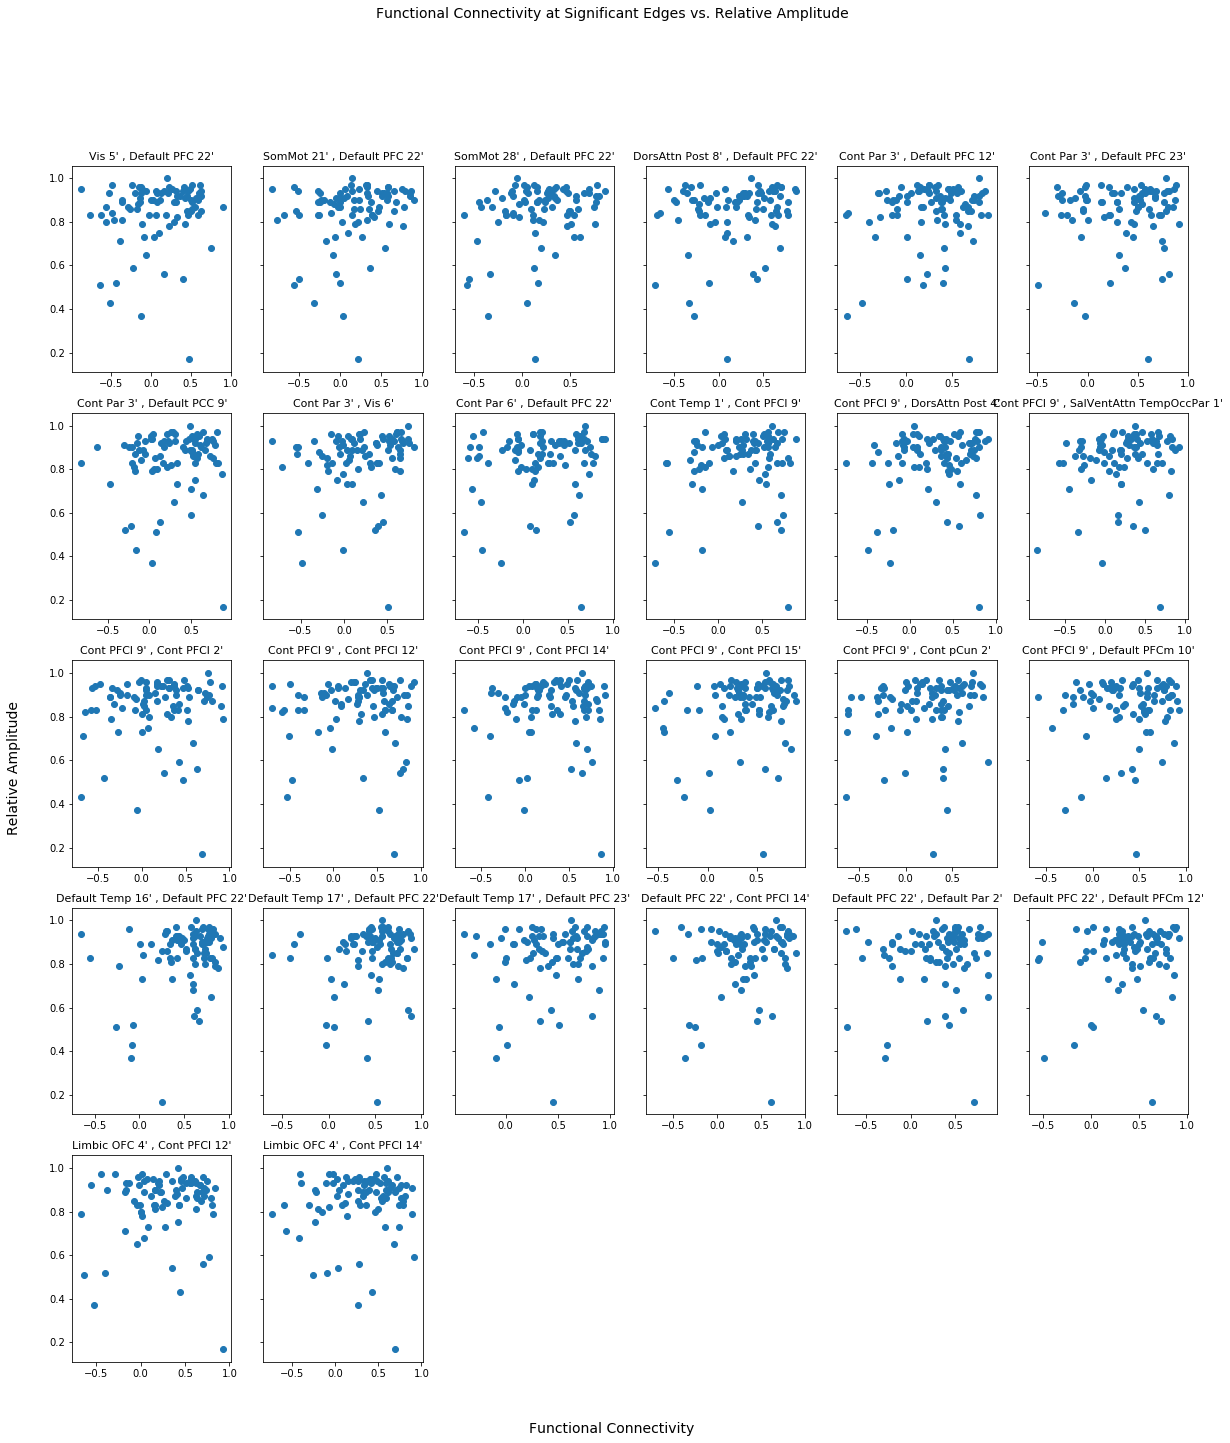

In [145]:
n_wide = 6
fig, axes = plt.subplots(5, n_wide,figsize=[20,22], sharey=True)
fig.suptitle('Functional Connectivity at Significant Edges vs. Relative Amplitude', size=14)

for edge in range(0,len(edgelist[0])):
    if edge < n_wide:
        axes[0, edge].scatter(cor[:,edge], RA)
        axes[0, edge].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)
    elif ((edge >= n_wide) & (edge < n_wide*2)):
        axes[1, edge-n_wide].scatter(cor[:,edge], RA)
        axes[1, edge-n_wide].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)
    elif ((edge >= n_wide*2) & (edge < n_wide*3)):
        axes[2, edge-n_wide*2].scatter(cor[:,edge], RA)
        axes[2, edge-n_wide*2].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)
    elif ((edge >= n_wide*3) & (edge < n_wide*4)):
        axes[3, edge-n_wide*3].scatter(cor[:,edge], RA)
        axes[3, edge-n_wide*3].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)
    else:
        axes[4, edge-n_wide*4].scatter(cor[:,edge], RA)
        axes[4, edge-n_wide*4].set_title(' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]), size=11)

        
fig.delaxes(axes[4][2])
fig.delaxes(axes[4][3])
fig.delaxes(axes[4][4])
fig.delaxes(axes[4][5])

fig.text(0.5, 0.08, 'Functional Connectivity', ha='center', size=14)
fig.text(0.08, 0.5, 'Relative Amplitude', va='center', rotation='vertical', size=14)


In [146]:
RA_n = pd.read_csv(os.path.join(work_dir, 'Analysis/cr_data_for_dsnmat.csv'), usecols=['record_id', 'RA'])
ef_n = pd.read_csv(os.path.join(work_dir, 'Analysis/neuropsych/ef_zscores.csv'), usecols=['record_id', 'ef_zscore'])
print(len(ef_n))

#making sure subject numbers are aligned 
ef_n = pd.merge(RA_n, ef_n, on='record_id')
print(len(ef_n))

ef_n = ef_n['ef_zscore'].values


92
88


In [148]:
import statsmodels.api as sm
for edge in range(0,len(edgelist[0])):
    print('\n \n' + ' '.join(str(labels[edgelist[0][edge]]).split('_')[2:5]) + ' , ' + ' '.join(str(labels[edgelist[1][edge]]).split('_')[2:5]))
    mod = sm.OLS(cor[:,edge], ef_n)
    res = mod.fit()
    print(res.summary())


 
Vis 5' , Default PFC 22'
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9559
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.331
Time:                        14:03:15   Log-Likelihood:                -46.180
No. Observations:                  88   AIC:                             94.36
Df Residuals:                      87   BIC:                             96.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0440   


 
Default PFC 22' , Cont PFCl 14'
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                  0.006243
Date:                Sun, 08 Sep 2019   Prob (F-statistic):              0.937
Time:                        14:03:15   Log-Likelihood:                -60.700
No. Observations:                  88   AIC:                             123.4
Df Residuals:                      87   BIC:                             125.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.

**Default Mode Network**

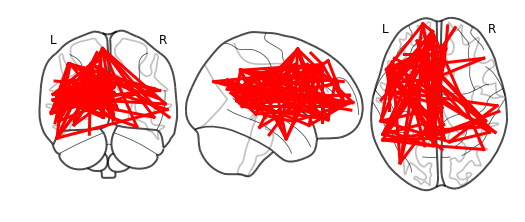

In [37]:
adj = np.loadtxt(os.path.join(work_dir, 'Analysis/rest/nbs_results/adj_RA-dmn.txt'))
plotting.plot_connectome(adj, np.asarray(schaefer_coords)[dmn_mask], node_size=0)

In [38]:
edgelist = np.where(np.triu(adj)==1)
fcmat_wb_cr[edgelist[0], edgelist[1], 0]

array([ 0.40742645,  0.39197327,  0.16841635,  0.37486295, -0.29810401,
        0.4064139 , -0.11542814,  0.12651646,  0.01290792,  0.23912067,
        0.51963987,  0.487822  , -0.30337738,  0.52552524,  0.3327329 ,
        0.40435813,  0.20146222, -0.00606624,  0.28441758,  0.20914789,
        0.03847493, -0.50853478,  0.34178418,  0.0778772 ,  0.25362999,
        0.10787009,  0.45448178, -0.37955153,  0.54407669, -0.64768447,
        0.28451815,  0.3835633 ,  0.30470792,  0.17282192,  0.68372836,
        0.55456908, -0.30384179, -0.31560243,  0.63928478,  0.12946775,
       -0.04362152, -0.07487828,  0.65832161,  0.22600717,  0.5112009 ,
        0.77414239, -0.49853102,  0.59647972,  0.63291954,  0.58623536,
        0.01233009, -0.23637349,  0.63074028,  0.58868345,  0.57048745,
        0.5732964 , -0.33747053, -0.27533831, -0.30122662, -0.60349731,
       -0.37373089,  0.20915595,  0.17633304, -0.24705948,  0.29298356,
        0.43039967,  0.3985772 ,  0.19438037,  0.54814216,  0.44

In [39]:
cor = []

for subject in range(0, np.ma.size(fcmat_wb_cr, 2)):
    cor.append(fcmat_wb_cr[edgelist[0], edgelist[1], subject])

cor = np.asarray(cor)

In [40]:
len(edgelist[0])

108

**Frontoparietal Control Network**

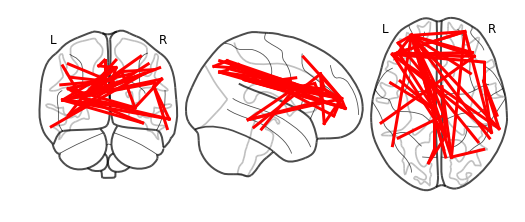

In [33]:
adj = np.loadtxt(os.path.join(work_dir, 'Analysis/rest/nbs_results/adj_RA-fpn.txt'))
plotting.plot_connectome(adj, np.asarray(schaefer_coords)[fpn_mask], node_size=0)

In [34]:
edgelist = np.where(np.triu(adj)==1)
fcmat_wb_cr[edgelist[0], edgelist[1], 0]

array([-0.42574624,  0.13933803,  0.07756755, -0.38248724, -0.50506504,
       -0.2671001 , -0.31384061,  0.77113675,  0.29302828,  0.37312383,
       -0.63569204,  0.22939154,  0.49047041,  0.30660136, -0.30779323,
        0.18683136,  0.73464553,  0.23709542,  0.30645522,  0.09043132,
        0.37114645,  0.56570669,  0.57048745,  0.26089655,  0.51276101,
        0.53936551,  0.23214898,  0.21583865,  0.10657648, -0.5315032 ,
       -0.03318672, -0.37491986,  0.67047596, -0.13436761,  0.91071437,
        0.25960211,  0.77584505,  0.48330168,  0.40813241,  0.88034538,
        0.5081287 ,  0.8126347 ])

In [35]:
cor = []

for subject in range(0, np.ma.size(fcmat_wb_cr, 2)):
    cor.append(fcmat_wb_cr[edgelist[0], edgelist[1], subject])

cor = np.asarray(cor)

In [36]:
len(edgelist[0])

42